In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'ieee', 'no-latex'])
import matplotlib.animation as animation

# Reduced units and system parameters
T_star = 1.5  # Reduced temperature
n_star = 0.9  # Reduced density
num_molecules = 500
n_dim = 3  # Number of dimensions

# Calculate box size for the given reduced density in nD
volume = num_molecules / n_star
box_size = volume ** (1/n_dim)  # Generalized for n dimensions

# Initialize positions in an n-dimensional lattice
np.random.seed(0)
positions = np.random.rand(num_molecules, n_dim) * box_size

def lennard_jones_potential(r):
    """ Calculate Lennard-Jones potential for a distance r in reduced units """
    r6 = (1 / r)**6  # sigma is 1 in reduced units
    r12 = r6**2
    return 4 * (r12 - r6)  # epsilon is 1 in reduced units

def potential_from_vectorized(molecule_index, all_positions):
    molecule_positions = all_positions[:, molecule_index, :]

    mask = np.ones(all_positions.shape[1], dtype=bool)
    mask[molecule_index] = False

    other_molecules = all_positions[:, mask, :]

    diff = molecule_positions[:, np.newaxis, :] - other_molecules
    diff = diff - np.round(diff / box_size) * box_size  # Periodic boundary conditions

    distances = np.sqrt(np.sum(diff**2, axis=-1))

    potentials = np.sum(lennard_jones_potential(distances), axis=1)
    
    return potentials

def potential_from(molecule_index, positions):
    molecule_position = positions[molecule_index]
    
    other_molecules = np.delete(positions, molecule_index, axis=0)
    
    diff = molecule_position - other_molecules
    diff = diff - np.round(diff / box_size) * box_size  # Periodic boundary conditions
    distances = np.sqrt(np.sum(diff**2, axis=-1))
    
    return np.sum(lennard_jones_potential(distances))

def total_potential_energy(positions):
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    diff = diff - np.round(diff / box_size) * box_size  # Periodic boundary conditions
    distances = np.sqrt(np.sum(diff**2, axis=-1))

    np.fill_diagonal(distances, np.inf)
    
    distances = distances[np.triu_indices(num_molecules, k=1)]

    return np.sum(lennard_jones_potential(distances)) 

def gibbs_step(positions):
    molecule_idx = np.random.randint(num_molecules)

    # For each dimension, do the sampling
    for dim in range(n_dim):
        variable_range = np.linspace(0, box_size, 100)
        fixed_values = positions[molecule_idx, np.setdiff1d(np.arange(n_dim), dim)]
        conditional = estimate_conditional_distribution(molecule_idx, positions, fixed_values, variable_range, dim)
        positions[molecule_idx, dim] = np.random.choice(variable_range, p=conditional)

    total_energy = total_potential_energy(positions)
    return positions, total_energy

def estimate_conditional_distribution(index, positions, fixed_values, variable_range, varying_dim):
    n = len(variable_range)

    varied_positions = np.tile(positions[index], (n, 1))
    varied_positions[:, varying_dim] = variable_range

    all_positions = np.tile(positions, (n, 1, 1))
    all_positions[:, index] = varied_positions

    potentials = -potential_from_vectorized(index, all_positions)
    probabilities = np.exp(potentials)
    probabilities[np.isnan(probabilities)] = 0
    if np.sum(probabilities) == 0:
        probabilities = np.ones_like(probabilities)
    probabilities /= np.sum(probabilities)
    
    return probabilities

In [25]:
# Initialize the total energy
total_energy = total_potential_energy(positions)
total_energy_history = [total_energy]

# Number of steps for the simulation
num_steps = 100

# Perform the simulation
positions_history = [positions.copy()]
for step in range(1, num_steps * num_molecules):
    positions, total_energy = gibbs_step(positions)
    positions_history.append(positions.copy())
    if (step % num_molecules == 0):
        total_energy_history.append(total_energy)


/var/folders/bd/rn8my1zs30g5ml3258f07ft80000gn/T/ipykernel_27129/3364977476.py:24: RuntimeWarning: divide by zero encountered in divide
  r6 = (1 / r)**6  # sigma is 1 in reduced units
/var/folders/bd/rn8my1zs30g5ml3258f07ft80000gn/T/ipykernel_27129/3364977476.py:26: RuntimeWarning: invalid value encountered in subtract
  return 4 * (r12 - r6)  # epsilon is 1 in reduced units


[1.0923057308749518e+18, 309920018.73368496, 45118998.89645451, -1914.8214651788746, -2374.1662564759617, -2551.7202754851323, -2673.615179636116, -2760.1249120024754, -2800.460997687539, -2830.0754547830093, -2829.6142676265185, -2875.3369277900774, -2857.4100388915303, -2902.888721685716, -2924.121205763245, -2923.693119108056, -2928.0227368234655, -2917.2887037666655, -2896.763218340927, -2917.9078159358096, -2876.3541550889913, -2912.135211509573, -2916.597642570404, -2910.005165528891, -2931.0056045202696, -2936.4336857445196, -2939.852275586702, -2940.719755775803, -2943.481644260388, -2951.980127017786, -2943.7942960174964, -2993.4605114198357, -2978.249616552817, -2966.34135447891, -2993.506900866173, -2928.2315653372802, -2957.9477167497253, -2966.419192384745, -2954.627757185661, -2936.0319281705006, -2939.5229882109575, -2960.3393078109184, -2962.187812102773, -2951.6984741149913, -2960.210721749365, -2950.908373156592, -2972.0131819694006, -2988.045538622577, -2977.56450776

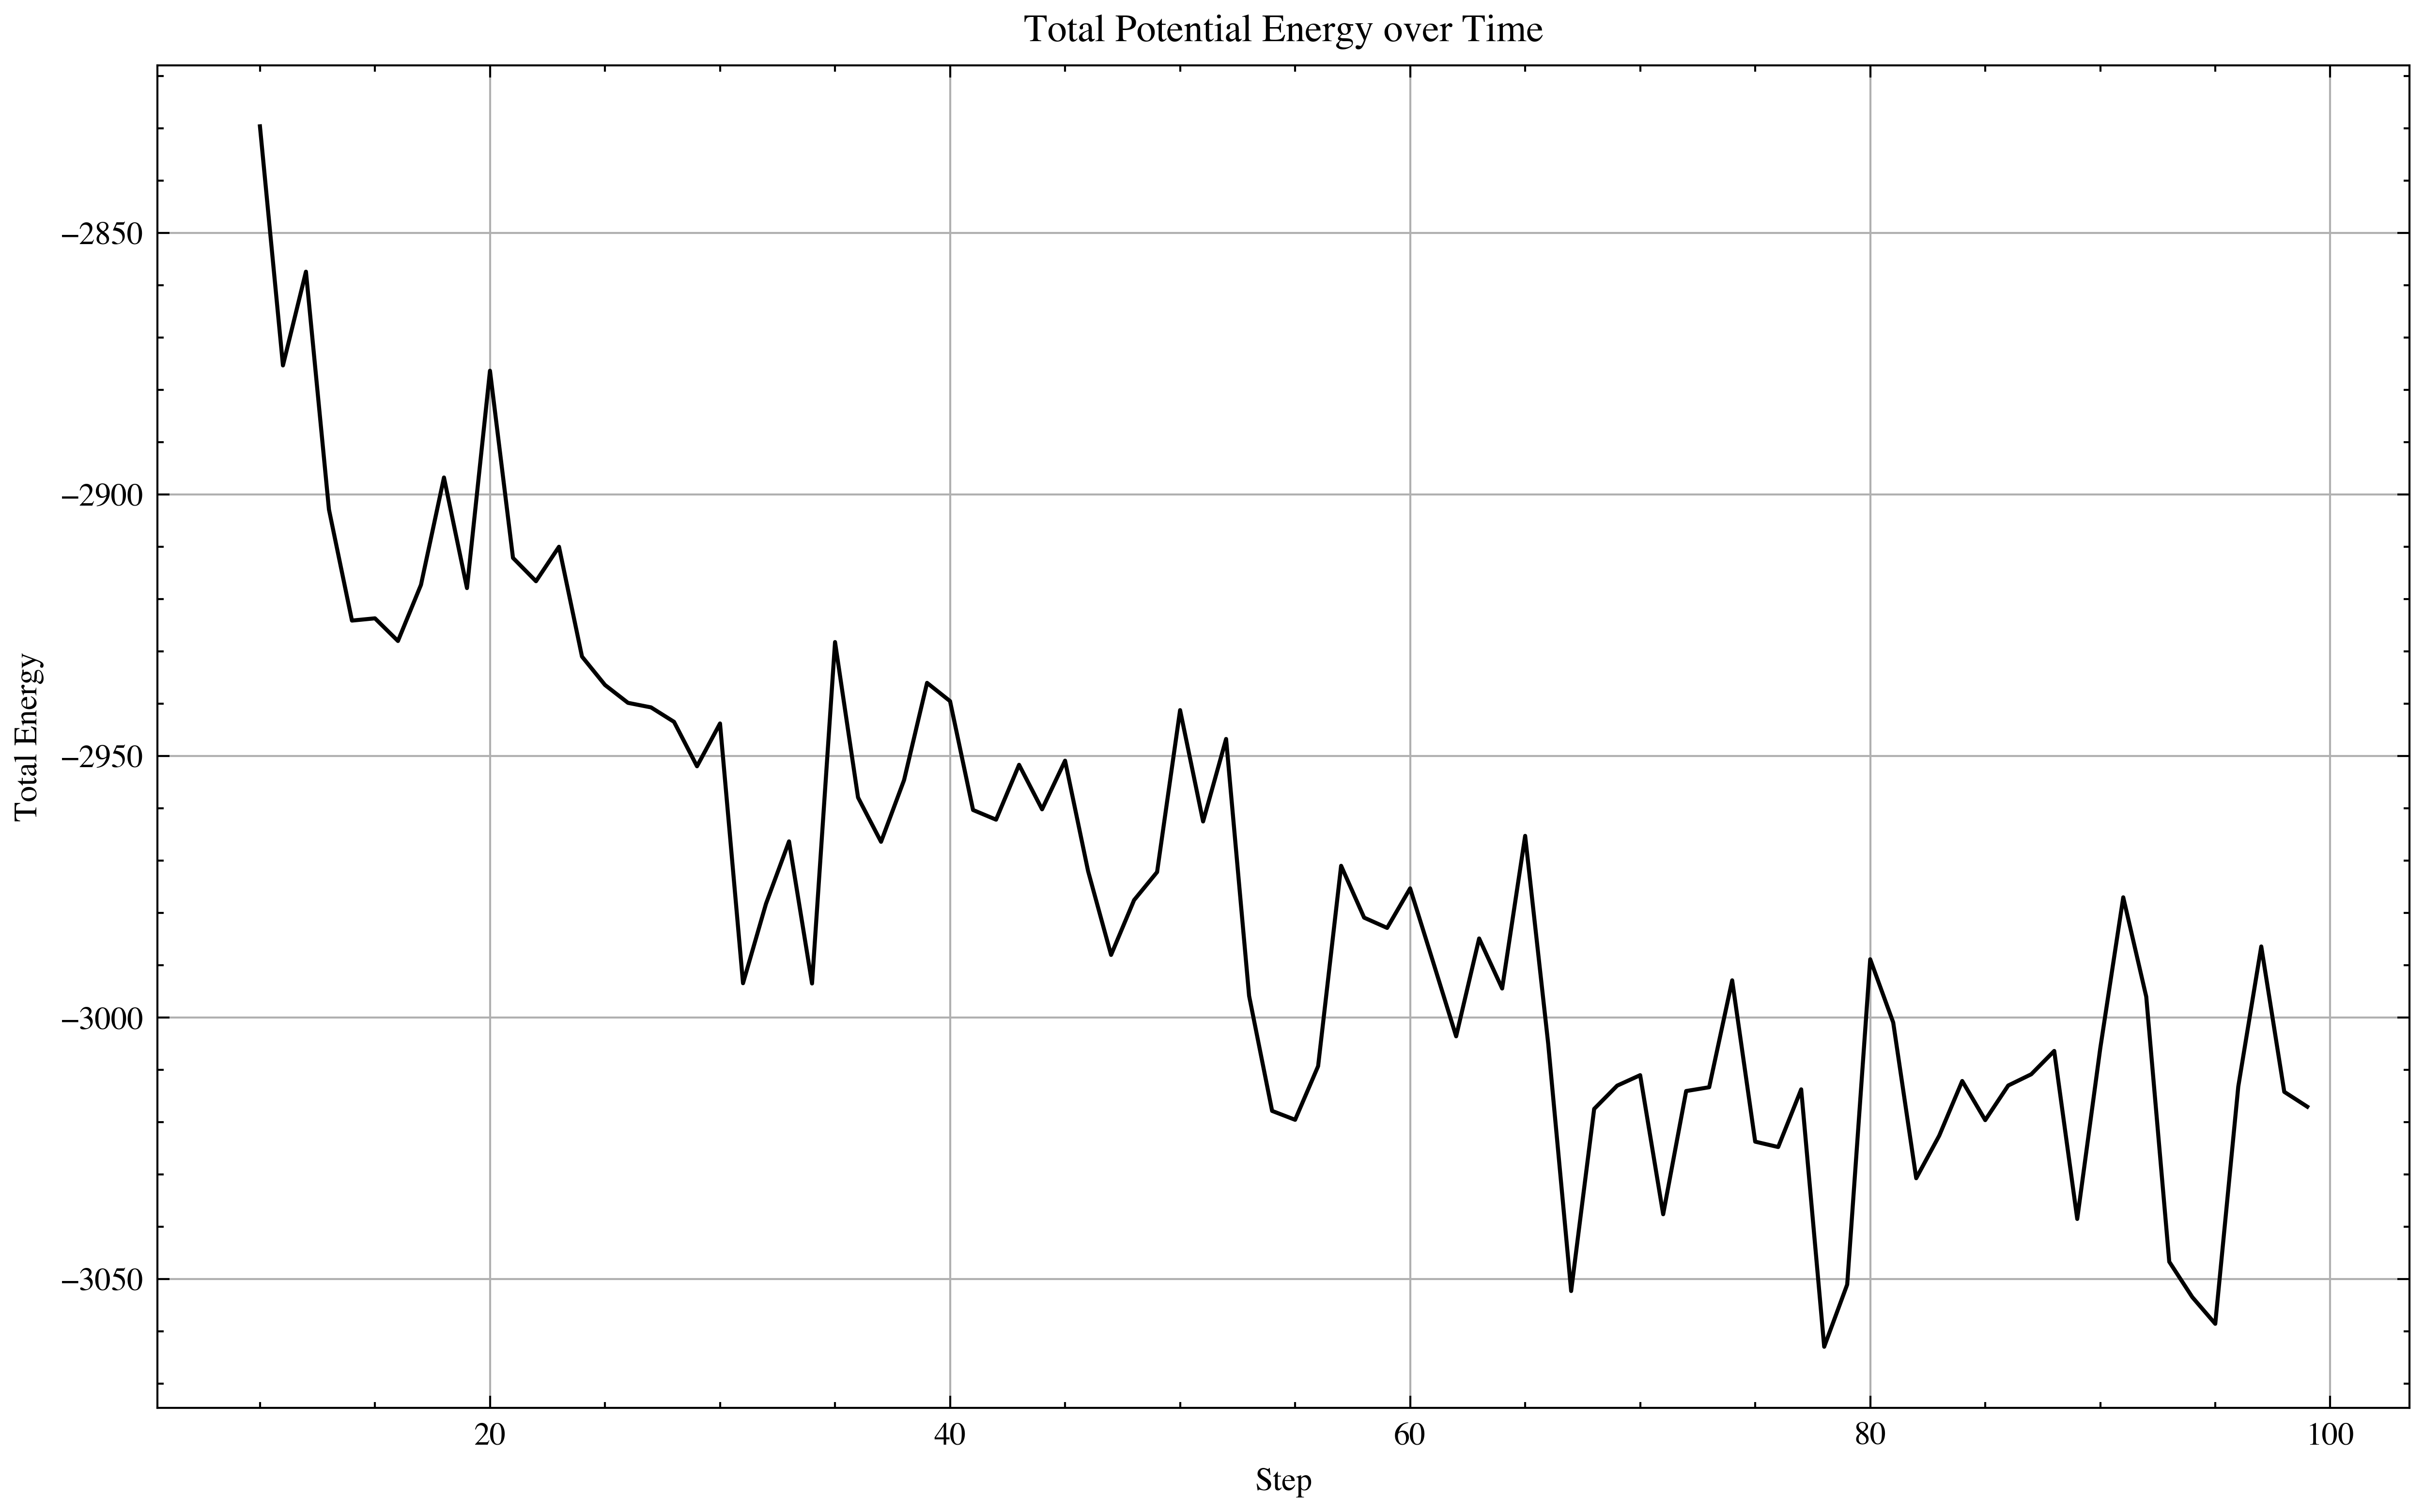

In [34]:
print(total_energy_history)
# Plotting the total energy over time
plt.figure(figsize=(10, 6))
plt.plot(range(10, len(total_energy_history)), total_energy_history[10:])
plt.title("Total Potential Energy over Time")
plt.xlabel("Step")
plt.ylabel("Total Energy")
plt.grid(True)
plt.show()

[       nan 0.         0.         0.         0.         0.
 0.         0.         0.         0.63312666 3.08053234 2.3208269
 1.38523747 0.83292133 0.61532693 0.63033217 0.69353977 0.903163
 1.16910113 1.34025215 1.34309088 1.21421307 1.03618783 0.93734606
 0.8860362  0.86467112 0.9752295  1.08965707 1.10749826 1.16112247
 1.09875857 1.0639772  0.98815602 0.94541381 0.95364467 0.99202972
 1.05666656 1.09875168 1.03751976 1.04522094 1.02853882]


/var/folders/bd/rn8my1zs30g5ml3258f07ft80000gn/T/ipykernel_27129/3415401626.py:25: RuntimeWarning: invalid value encountered in divide
  rdf = hist / (factor * bin_width * rho * N)


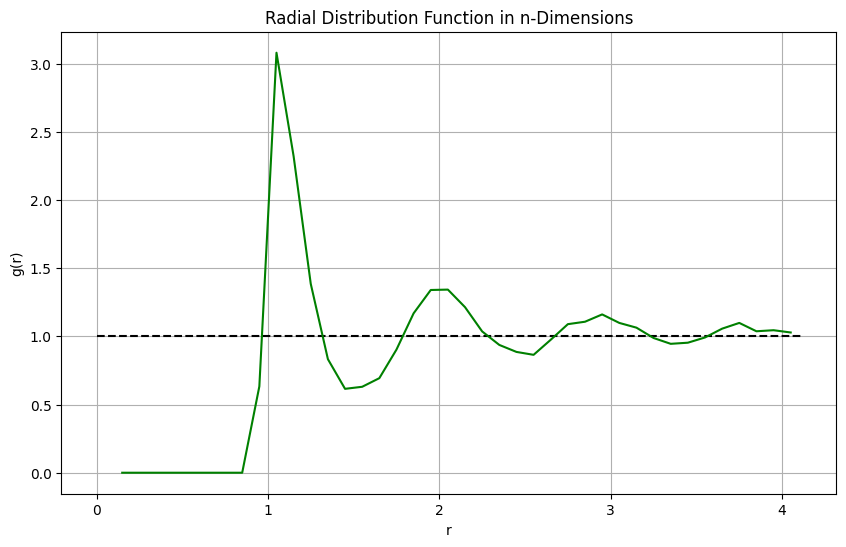

In [56]:
from scipy.interpolate import UnivariateSpline
from scipy.special import gamma
import numpy as np
import matplotlib.pyplot as plt

def compute_rdf(positions, L, N, bin_width, max_range, n_dim):
    def compute_distances(positions):
        diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
        diff = diff - np.round(diff / L) * L
        distances = np.sqrt(np.sum(diff**2, axis=-1))
        return distances[np.triu_indices(N, k=1)]

    distances = compute_distances(positions)

    # Histogram
    bins = np.arange(0, max_range, bin_width)
    hist, bin_edges = np.histogram(distances, bins=bins, density=False)

    # Normalize RDF
    rho = N / L**n_dim  # Number density in nD

    # Factor for normalization in nD
    factor = (np.pi**(n_dim / 2)) / gamma(n_dim / 2) * bin_edges[:-1]**(n_dim - 1)

    rdf = hist / (factor * bin_width * rho * N)

    # Compute bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    return bin_centers, rdf

# Example usage
n_dim = 3  # Example dimension
bin_centers, rdf = compute_rdf(positions_history[-1], box_size, num_molecules, 0.1, box_size / 2, n_dim)
print(rdf)

spline = UnivariateSpline(bin_centers[1:], rdf[1:])
spline.set_smoothing_factor(2.0)

# Generate a smooth curve for plotting
x_fit = np.linspace(bin_centers[1], bin_centers[-1], 500)
y_spline = spline(x_fit)

# Plotting the radial distribution function
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, box_size / 2, 500), np.ones(500), color='black', linestyle='dashed')
#plt.plot(x_fit, y_spline, color='red')
plt.plot(bin_centers, rdf, color='green')
plt.title("Radial Distribution Function in n-Dimensions")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.grid(True)
plt.show()


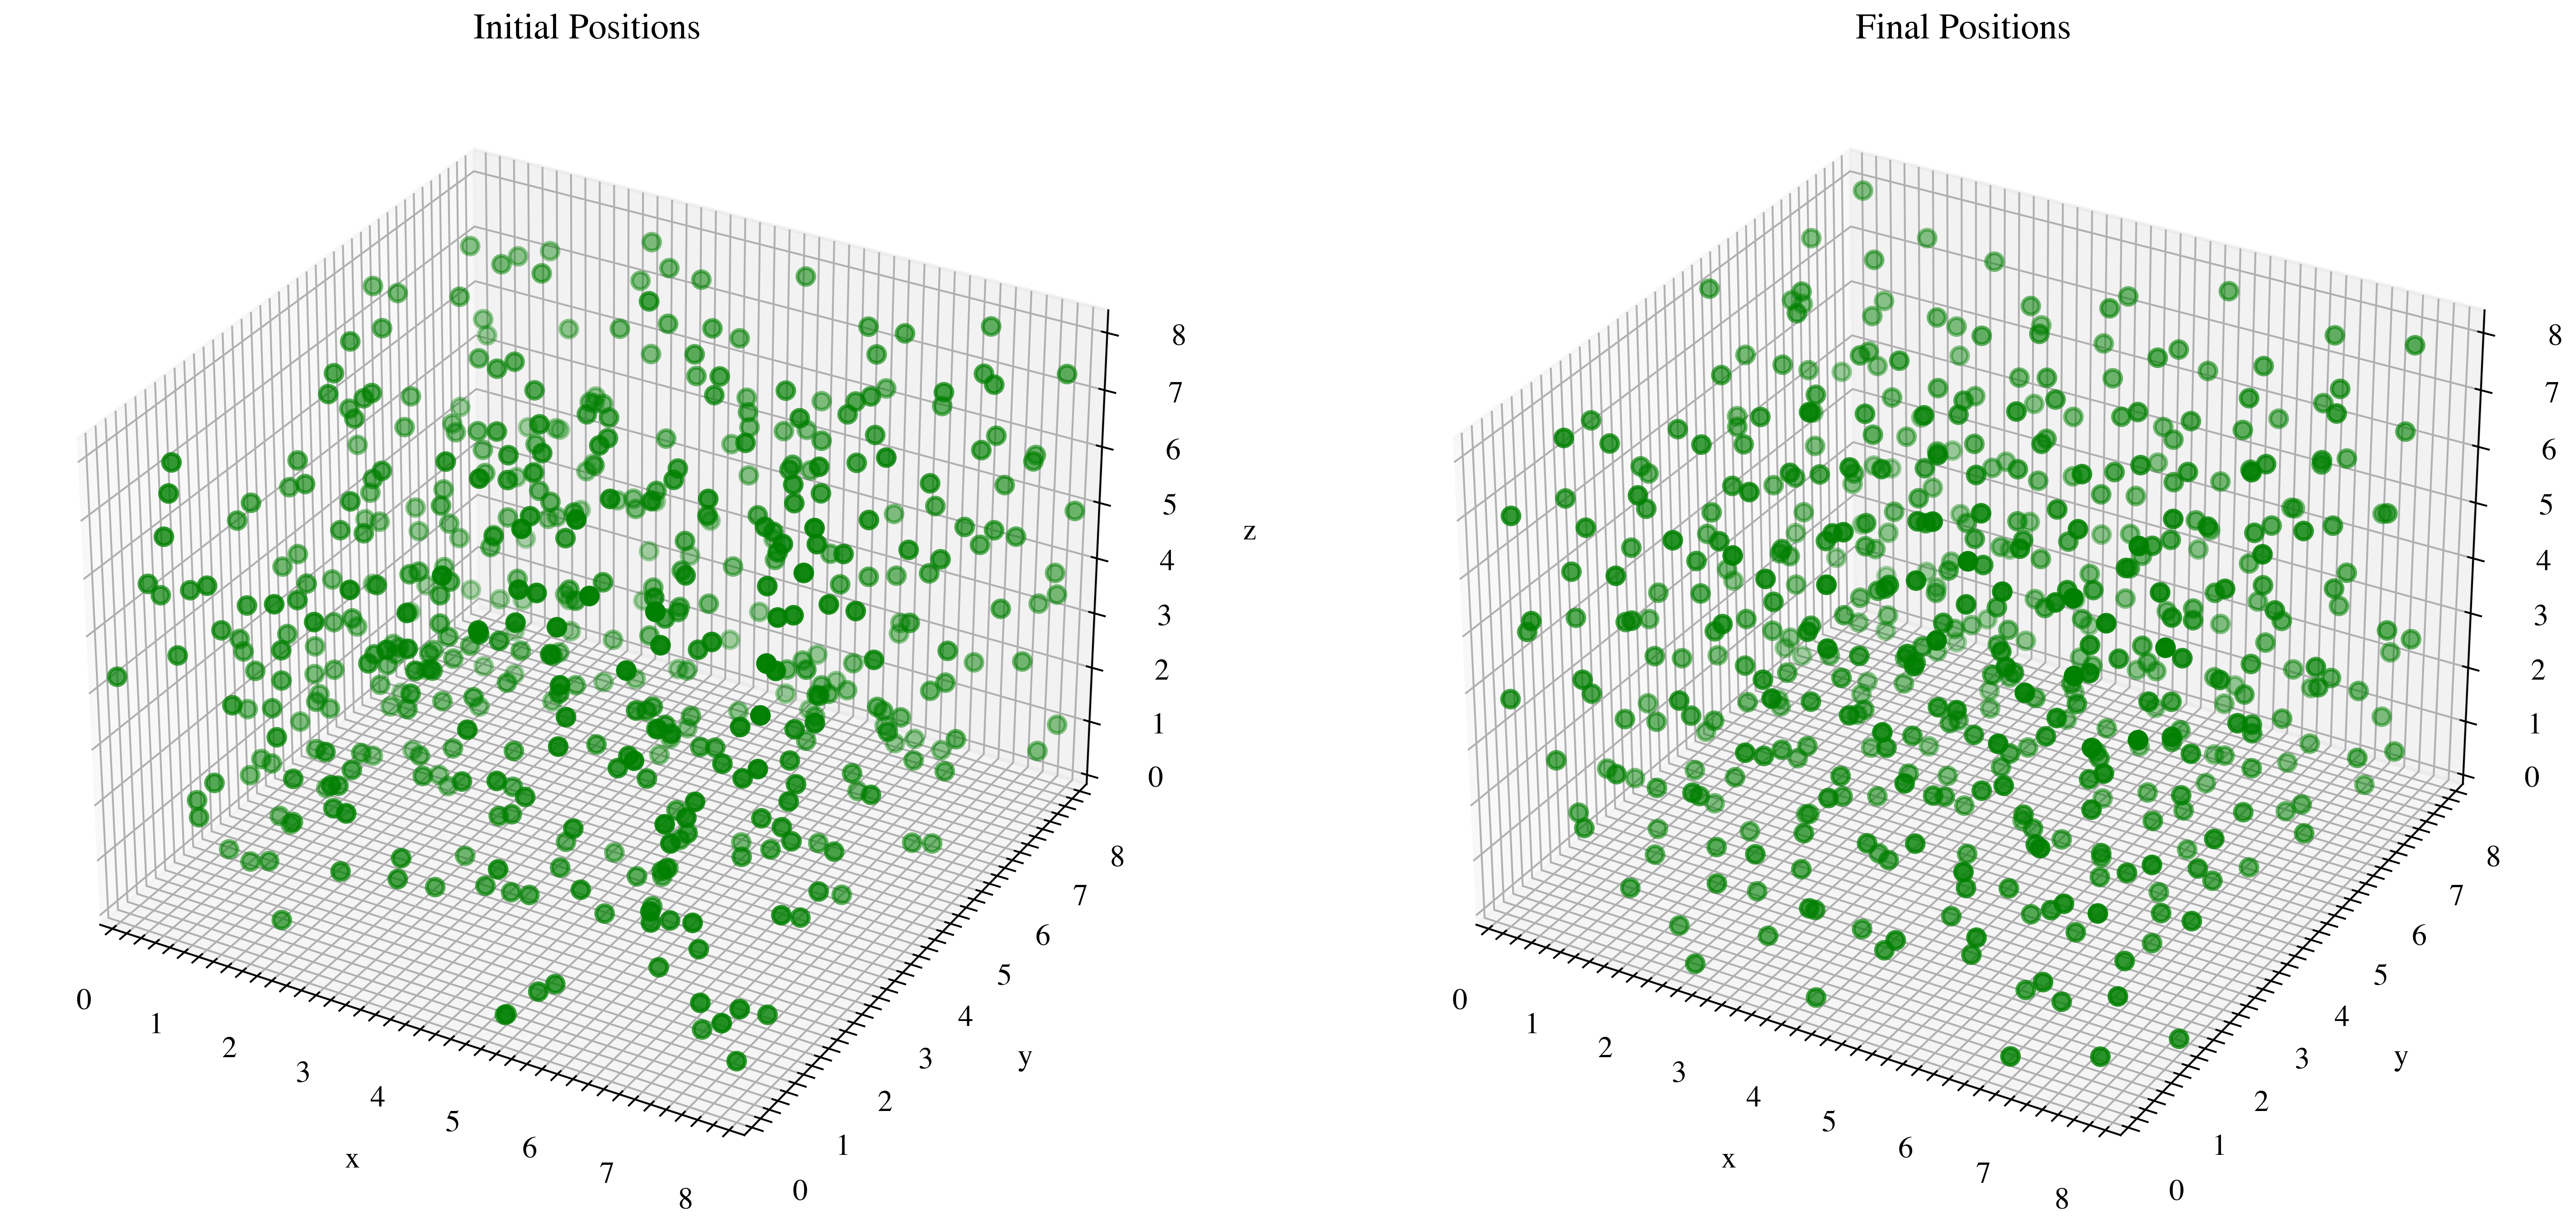

In [28]:
# Plot the initial and final positions of the molecules
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(positions_history[0][:, 0], positions_history[0][:, 1], positions_history[0][:, 2], color='green')
ax1.set_title("Initial Positions")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_xlim(0, box_size)
ax1.set_ylim(0, box_size)
ax1.set_zlim(0, box_size)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(positions_history[-1][:, 0], positions_history[-1][:, 1], positions_history[-1][:, 2], color='green')
ax2.set_title("Final Positions")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_xlim(0, box_size)
ax2.set_ylim(0, box_size)
ax2.set_zlim(0, box_size)

plt.show()
